# Фаза 2 • Неделя 2 • Понедельник
## Компьютерное зрение
### Локализация объектов

In [1]:
import sys, types, importlib
imp = types.ModuleType("imp")
imp.reload = importlib.reload
sys.modules["imp"] = imp

In [2]:
%load_ext autoreload
%autoreload

In [3]:
!pip install torchmetrics

In [4]:

import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional.detection.iou import intersection_over_union

from PIL import Image, ImageOps
# from src.mnist_localization import get_dataloaders
from sample_data.mnist_localization import get_dataloaders

In [5]:
# данные для этой задачи сгенерируем автоматически с помощью фунцкии
train_loader, valid_loader = get_dataloaders()

In [6]:
# Заберем один батч и проверим размеры данных: картинки, таргета и координат боксов
pic, label, true_box = next(iter(train_loader))
print(pic.shape, label.shape, true_box.shape)

torch.Size([32, 1, 100, 100]) torch.Size([32, 1]) torch.Size([32, 4])


In [7]:
# запишем в переменную размер картинки
IMG_SIZE = pic.shape[-1]
pic.shape

torch.Size([32, 1, 100, 100])

[]

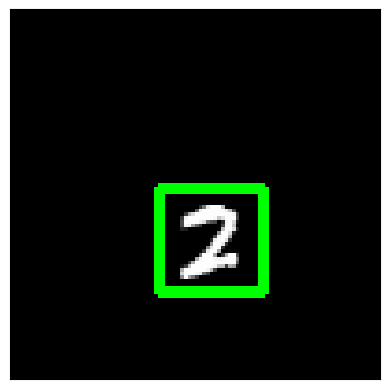

In [8]:
# Создаем область отрисовки картинки
fig, ax = plt.subplots(1, 1, squeeze=True)
# выбираем номер объекта из батча
k = 30
assert k < train_loader.batch_size, f"Batch size is 32, but k={k}"
# выбираем картинку и преобразовываем в numpy array
img = pic[k][0].cpu().numpy()
# конвертируем в cv2 – она умеет рисовать поверх
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# создаем прямоугольник
pic_label = cv2.rectangle(
    img,
    ((true_box[k][:2]*IMG_SIZE).numpy().astype('int')), # координаты левого верхнего угла рамки
    ((true_box[k][2:]*IMG_SIZE).numpy().astype('int')), # координаты правого нижнего угла рамки
    color=(0, 255, 0), thickness=2 # красный цвет, толщина 2
    )
ax.imshow(pic_label) # рисуем все вместе
ax.set_xticks([]); ax.set_yticks([]) # убираем тики

In [9]:
class LocalizationModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 5, stride=2),
            nn.GELU(),
            nn.Conv2d(8, 4, 5),
            nn.GELU()
        )

        # classification head: n_outputs = 10 (цифры 0–9)
        self.clf_head = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(64),
            nn.GELU(),
            nn.Linear(64, 10)
        )

        # box regression head: n_outputs = 4 (x1, y1, x2, y2) в [0,1]
        self.box_head = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(64),
            nn.GELU(),
            nn.Linear(64, 4)
        )

    def forward(self, pic: torch.Tensor):
        feats = self.backbone(pic)
        clf_out  = self.clf_head(feats)
        box_out  = self.box_head(feats)
        return clf_out, torch.sigmoid(box_out)

model = LocalizationModel()

In [10]:
optimizer = optim.SGD(model.parameters(), lr=.005, nesterov=True, momentum=.7)

Train stage: clf_loss: 0.661 reg_loss: 0.025 total_loss: 0.795 accuracy: 0.782 iou: 0.851
valid stage: clf_loss: 0.573 reg_loss: 0.023 total_loss: 0.681 accuracy: 0.811 iou: 0.858


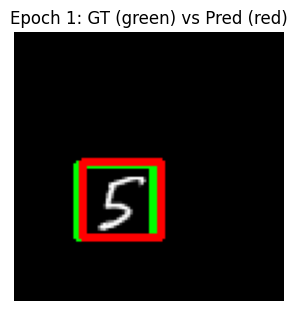

Train stage: clf_loss: 0.579 reg_loss: 0.023 total_loss: 0.674 accuracy: 0.811 iou: 0.857
valid stage: clf_loss: 0.510 reg_loss: 0.021 total_loss: 0.589 accuracy: 0.837 iou: 0.865


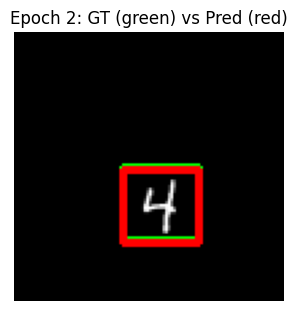

Train stage: clf_loss: 0.514 reg_loss: 0.022 total_loss: 0.584 accuracy: 0.836 iou: 0.861
valid stage: clf_loss: 0.447 reg_loss: 0.022 total_loss: 0.507 accuracy: 0.857 iou: 0.861


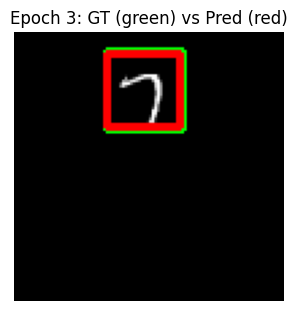

Train stage: clf_loss: 0.451 reg_loss: 0.021 total_loss: 0.505 accuracy: 0.857 iou: 0.862
valid stage: clf_loss: 0.416 reg_loss: 0.019 total_loss: 0.466 accuracy: 0.867 iou: 0.869


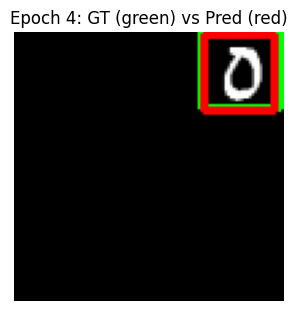

Train stage: clf_loss: 0.404 reg_loss: 0.021 total_loss: 0.446 accuracy: 0.873 iou: 0.864
valid stage: clf_loss: 0.352 reg_loss: 0.021 total_loss: 0.393 accuracy: 0.890 iou: 0.863


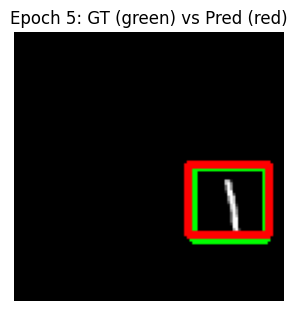

In [15]:
# возьмём device из модели (cuda, если доступна)
device = next(model.parameters()).device

log = dict()
log['epoch_train_clf_loss'] = []
log['epoch_valid_clf_loss'] = []
log['epoch_train_box_loss'] = []
log['epoch_valid_box_loss'] = []
log['epoch_train_total_loss'] = []
log['epoch_valid_total_loss'] = []
log['epoch_train_accuracy'] = []
log['epoch_valid_accuracy'] = []
log['epoch_train_iou'] = []
log['epoch_valid_iou'] = []
for i in range(5):
    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []
    model.train()
    for images, labels, boxes in train_loader:
        ############################
        # logits: выход классификатора
        # coords: выход регрессии на координаты
        # код тут
        ############################
        images = images.to(device)
        labels = labels.to(device)
        boxes  = boxes.to(device)
        logits, coords = model(images)

        loss_clf = F.cross_entropy(logits, labels.squeeze().long())
        # (предсказание, таргет)
        loss_box = F.smooth_l1_loss(coords, boxes, reduction='sum', beta=.6)
        iou = intersection_over_union(coords, boxes)
        accuracy = (logits.argmax(1) == labels.squeeze()).sum()/labels.size(0)
        batch_acc.append(accuracy.item())
        batch_iou.append(iou.item())

        total_loss = loss_clf * (1 / (accuracy.item()+1e-1)) + loss_box * (1 / (iou.item()+1e-1))
        total_loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        batch_reg_loss.append(loss_box.item())
        batch_clf_loss.append(loss_clf.item())
        batch_total_loss.append(total_loss.item())

    log['epoch_train_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_train_box_loss'].append(np.mean(batch_reg_loss))
    log['epoch_train_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_train_accuracy'].append(np.mean(batch_acc))
    log['epoch_train_iou'].append(np.mean(batch_iou))


    batch_clf_loss = []
    batch_reg_loss = []
    batch_acc = []
    batch_iou = []
    batch_total_loss = []
    model.eval()
    for images, labels, boxes in valid_loader:
        #########################
        # твой код тут
        #########################
        images = images.to(device)
        labels = labels.to(device)
        boxes  = boxes.to(device)
        with torch.no_grad():
            logits, coords = model(images)
            loss_clf = F.cross_entropy(logits, labels.squeeze().long())
            loss_box = F.smooth_l1_loss(coords, boxes, reduction='sum', beta=.6)
            iou = intersection_over_union(coords, boxes)
            accuracy = (logits.argmax(1) == labels.squeeze()).sum()/labels.size(0)

            total_loss = loss_clf * (1 / (accuracy.item()+1e-1)) + loss_box * (1 / (iou.item()+1e-1))

        batch_reg_loss.append(loss_box.item())
        batch_clf_loss.append(loss_clf.item())
        batch_total_loss.append(total_loss.item())
        batch_acc.append(accuracy.item())
        batch_iou.append(iou.item())

    log['epoch_valid_clf_loss'].append(np.mean(batch_clf_loss))
    log['epoch_valid_box_loss'].append(np.mean(batch_reg_loss))
    log['epoch_valid_total_loss'].append(np.mean(batch_total_loss))
    log['epoch_valid_accuracy'].append(np.mean(batch_acc))
    log['epoch_valid_iou'].append(np.mean(batch_iou))

    print(f"Train stage: clf_loss: {log['epoch_train_clf_loss'][-1]:.3f} reg_loss: {log['epoch_train_box_loss'][-1]:.3f} total_loss: {log['epoch_train_total_loss'][-1]:.3f} accuracy: {log['epoch_train_accuracy'][-1]:.3f} iou: {log['epoch_train_iou'][-1]:.3f}")
    print(f"valid stage: clf_loss: {log['epoch_valid_clf_loss'][-1]:.3f} reg_loss: {log['epoch_valid_box_loss'][-1]:.3f} total_loss: {log['epoch_valid_total_loss'][-1]:.3f} accuracy: {log['epoch_valid_accuracy'][-1]:.3f} iou: {log['epoch_valid_iou'][-1]:.3f}")

    #######################
    # блок визуализации результатов
    # доработай его так, чтобы после каждой эпохи распечатывалась картинка
    # с оригинальным боксом и предсказанным боксом (пример ниже)
    #######################

    model.eval()
    with torch.no_grad():
        images_v, labels_v, boxes_v = next(iter(valid_loader))
        images_v = images_v.to(device)
        boxes_v  = boxes_v.to(device)
        _, coords_v = model(images_v)

    # возьмём случайный пример из батча
    k = np.random.randint(0, images_v.size(0))

    # приводим картинку к uint8 и RGB для рисования
    img = images_v[k, 0].detach().cpu().numpy()  # [H, W], float
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # [0,1]
    img_rgb = (img * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)

    # переводим нормированные боксы в пиксели
    H, W = img_rgb.shape[:2]
    scale = np.array([W, H, W, H])
    gt = (boxes_v[k].detach().cpu().numpy()  * scale).astype(int)
    pr = (coords_v[k].detach().cpu().numpy() * scale).astype(int)

    # аккуратно ограничим координаты рамок границами изображения
    gt = np.clip(gt, [0,0,0,0], [W-1, H-1, W-1, H-1])
    pr = np.clip(pr, [0,0,0,0], [W-1, H-1, W-1, H-1])

    # рисуем: GT — зелёный, Pred — красный
    vis = img_rgb.copy()
    cv2.rectangle(vis, (gt[0], gt[1]), (gt[2], gt[3]), color=(0,255,0), thickness=2)
    cv2.rectangle(vis, (pr[0], pr[1]), (pr[2], pr[3]), color=(255,0,0), thickness=2)

    plt.figure(figsize=(3.5, 3.5))
    plt.imshow(vis)
    plt.title(f"Epoch {i+1}: GT (green) vs Pred (red)")
    plt.axis('off')
    plt.show()


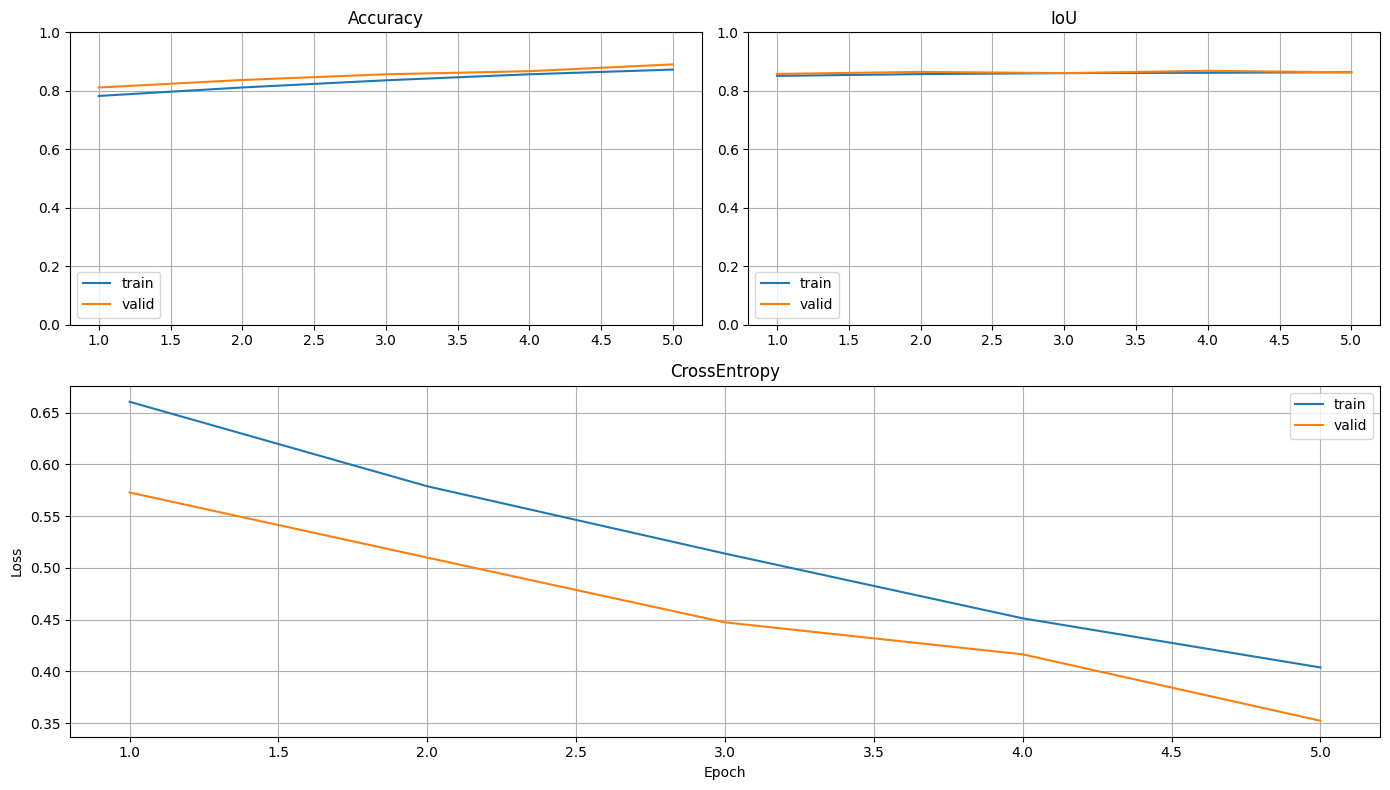

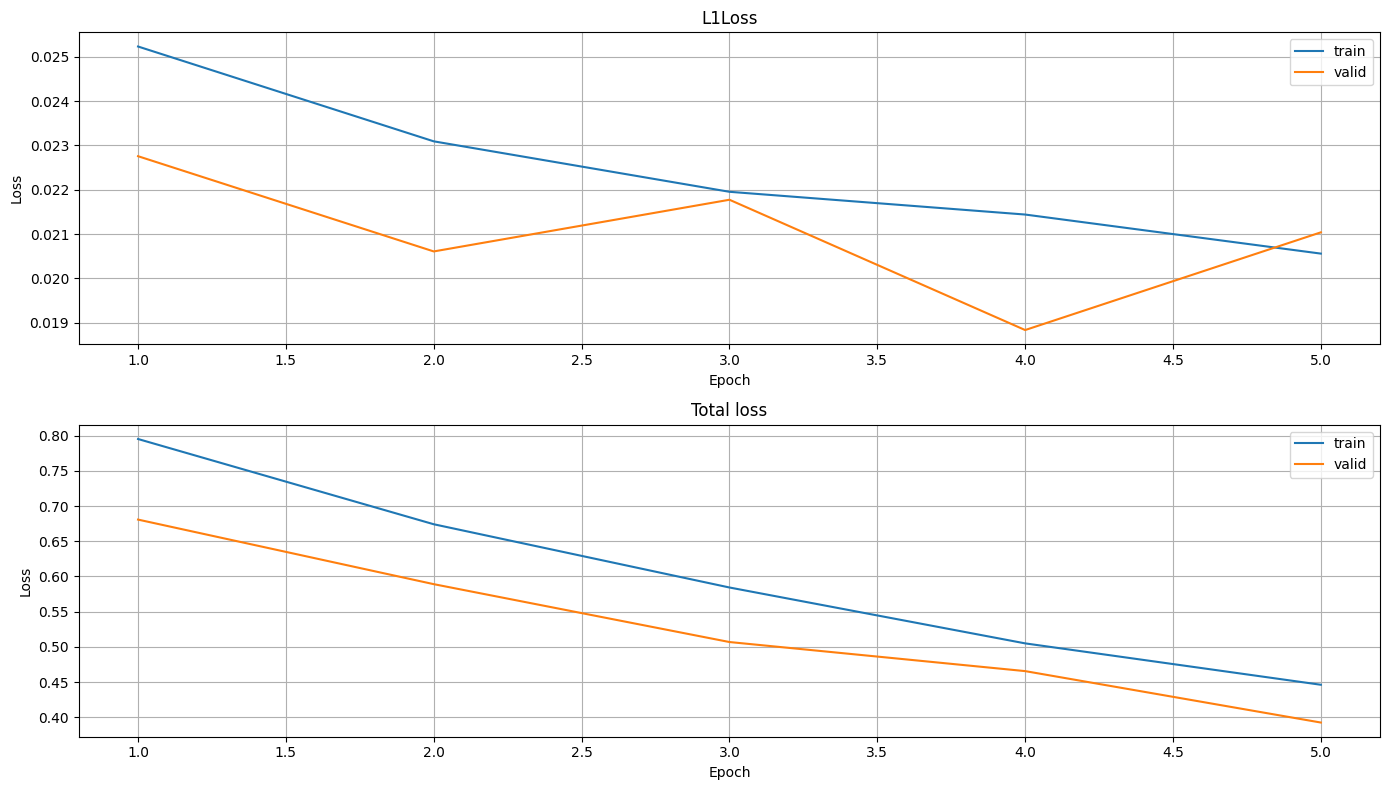

In [16]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(log['epoch_train_clf_loss']) + 1)

# --- Фигура 1: Accuracy | IoU | CrossEntropy (внизу на всю ширину) ---
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

ax_acc = fig.add_subplot(gs[0, 0])
ax_iou = fig.add_subplot(gs[0, 1])
ax_ce  = fig.add_subplot(gs[1, :])  # нижний — на всю ширину

# Accuracy
ax_acc.plot(epochs, log['epoch_train_accuracy'], label='train')
ax_acc.plot(epochs, log['epoch_valid_accuracy'], label='valid')
ax_acc.set_title('Accuracy'); ax_acc.set_ylim(0, 1); ax_acc.grid(True); ax_acc.legend()

# IoU
ax_iou.plot(epochs, log['epoch_train_iou'], label='train')
ax_iou.plot(epochs, log['epoch_valid_iou'], label='valid')
ax_iou.set_title('IoU'); ax_iou.set_ylim(0, 1); ax_iou.grid(True); ax_iou.legend()

# CrossEntropy (классификация)
ax_ce.plot(epochs, log['epoch_train_clf_loss'], label='train')
ax_ce.plot(epochs, log['epoch_valid_clf_loss'], label='valid')
ax_ce.set_title('CrossEntropy'); ax_ce.set_xlabel('Epoch'); ax_ce.set_ylabel('Loss'); ax_ce.grid(True); ax_ce.legend()

plt.tight_layout()
plt.show()

# --- Фигура 2: L1Loss | Total loss ---
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 1)

ax_l1 = fig.add_subplot(gs[0, 0])
ax_tot = fig.add_subplot(gs[1, 0])

# L1Loss (регрессия бокса)
ax_l1.plot(epochs, log['epoch_train_box_loss'], label='train')
ax_l1.plot(epochs, log['epoch_valid_box_loss'], label='valid')
ax_l1.set_title('L1Loss'); ax_l1.set_xlabel('Epoch'); ax_l1.set_ylabel('Loss'); ax_l1.grid(True); ax_l1.legend()

# Total loss
ax_tot.plot(epochs, log['epoch_train_total_loss'], label='train')
ax_tot.plot(epochs, log['epoch_valid_total_loss'], label='valid')
ax_tot.set_title('Total loss'); ax_tot.set_xlabel('Epoch'); ax_tot.set_ylabel('Loss'); ax_tot.grid(True); ax_tot.legend()

plt.tight_layout()
plt.show()

Такой результат должен выводиться после каждой эпохи:

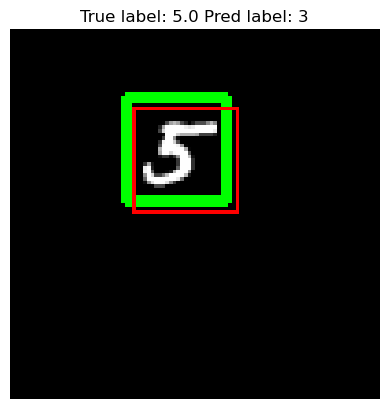

In [19]:
from IPython.display import Image, display
display(Image("sample_data/output.png"))

Визуализируй все лоссы и метрики, которые были собраны в процессе обучения. Пример диаграммы ниже.

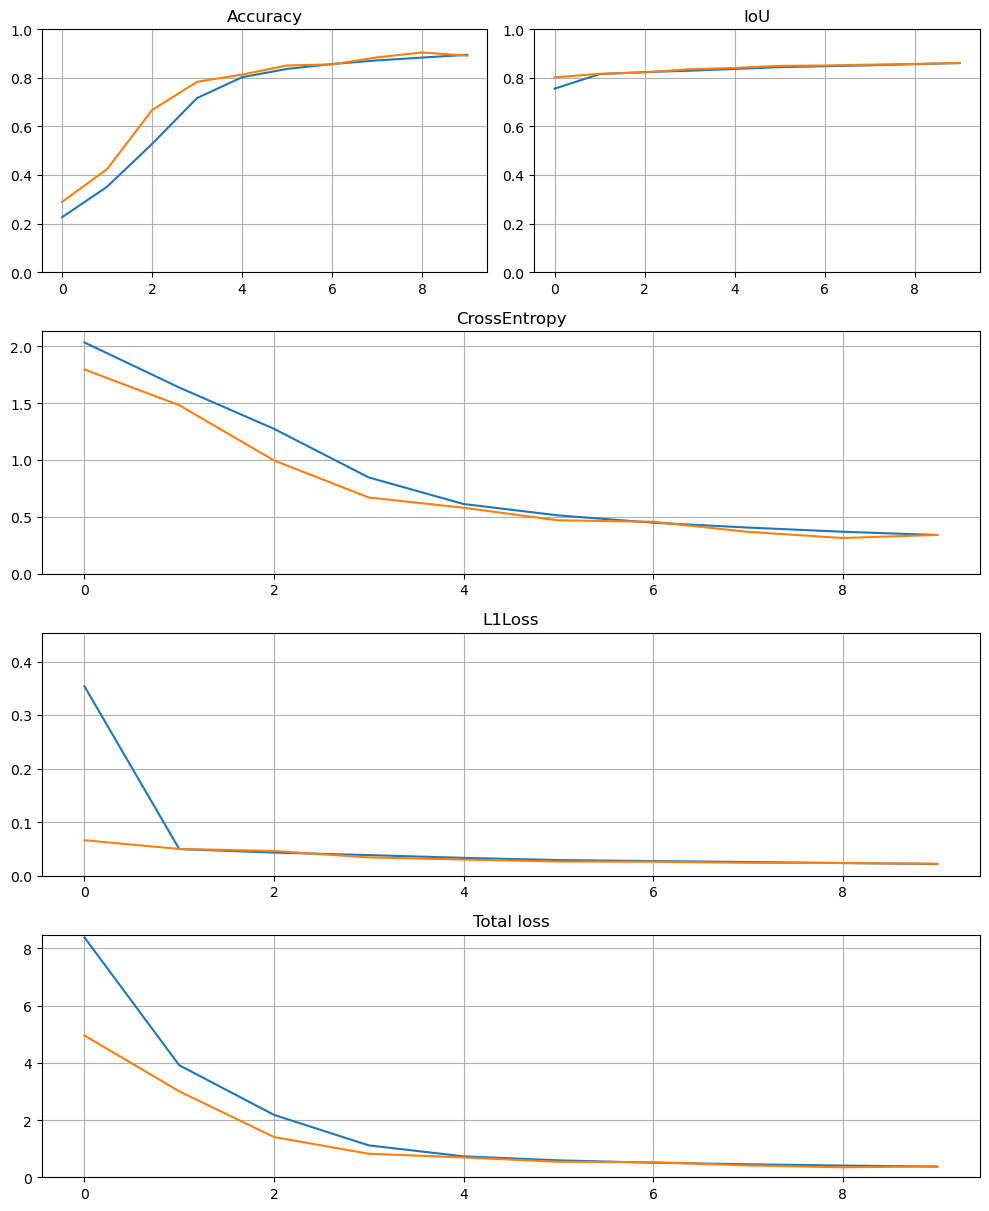

In [20]:
from IPython.display import Image, display
display(Image("/content/sample_data/training_curves.png"))
